In [1]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle
from PIL import Image
import urllib

In [2]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

In [3]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640737/Live/England-Premier-League-2022-2023-Fulham-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640737


In [4]:
homeID = home_data['teamId']
awayID = away_data['teamId']

## Colours 

In [5]:
home_color = '#9C9C9C'
away_color = '#2D5DE7'

## Get 11 players with most minutes  

In [6]:
# For the main team (one we're interested in)
team_players = events_df[events_df.teamId == homeID].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team_players = pd.concat([team_players['playerName'], team_players['minute']], axis=1)
team_players['mins_played'] = team_players['max'] - team_players['min']
team_players = team_players.sort_values('mins_played', ascending=False)
team_players_names = team_players.playerName
team_players_names_top11 = team_players.playerName[:11].tolist()
team_players_names_top11

# For the other team
team2_players = events_df[events_df.teamId == awayID].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team2_players = pd.concat([team2_players['playerName'], team2_players['minute']], axis=1)
team2_players['mins_played'] = team2_players['max'] - team2_players['min']
team2_players = team2_players.sort_values('mins_played', ascending=False)
team2_players_names = team2_players.playerName
team2_players_names_top11 = team2_players.playerName[:11].tolist()

team_players_names_top11


['Tosin Adarabioyo',
 'Bernd Leno',
 'Tim Ream',
 'Antonee Robinson',
 'Carlos Vinícius',
 'Kenny Tete',
 'Andreas Pereira',
 'João Palhinha',
 'Willian',
 'Harrison Reed',
 'Bobby De Cordova-Reid']

## Get zones and split touches into particular zones 

In [7]:
touches = events_df[events_df['isTouch'] == True].reset_index(drop=True)[['x','y', 'teamId']]
touches.head(30)

,x,y,teamId
0,49.9,50.1,170
1,29.9,34.3,170
2,73.9,92.6,170
3,20.9,14.2,15
4,20.4,9.4,15
5,77.8,87.0,170
6,75.3,88.1,170
7,72.0,93.3,170
8,13.2,46.6,15
9,25.3,69.6,15


In [8]:
# Need to invert coords for away team since both in same standard, i.e. attacking towards high x
for i in range(len(touches)):
    if touches['teamId'][i] == awayID:
        touches['x'][i] = 100 - touches['x'][i]
        touches['y'][i] = 100 - touches['y'][i]
touches.head(30)

,x,y,teamId
0,49.9,50.1,170
1,29.9,34.3,170
2,73.9,92.6,170
3,79.1,85.8,15
4,79.6,90.6,15
5,77.8,87.0,170
6,75.3,88.1,170
7,72.0,93.3,170
8,86.8,53.4,15
9,74.7,30.4,15


In [9]:
zones = []
for i in range(5):
    row = []
    for j in range(6):
        zone = i + ((j)*5)
        row.append(zone)
    zones.append(row)
zones = np.array(zones)
zones

array([[ 0,  5, 10, 15, 20, 25],
       [ 1,  6, 11, 16, 21, 26],
       [ 2,  7, 12, 17, 22, 27],
       [ 3,  8, 13, 18, 23, 28],
       [ 4,  9, 14, 19, 24, 29]])

In [10]:
# zones_rows, zones_cols = zones.shape
# (zones_rows, zones_cols )

zones_rows= [0, 17, 33.5, 50, 66.5, 83, 100]
zones_rows = np.array(zones_rows, dtype='object')

zones_cols = [0, 21.1, 36.8, 63.2, 78.9, 100]
zones_cols = np.array(zones_cols, dtype='object')

In [11]:
for i in range(len(touches)):
    touches['x_bin'] = pd.cut(touches['x'], bins=zones_rows, labels=False, include_lowest=True)
    touches['y_bin'] = pd.cut(touches['y'], bins=zones_cols, labels=False, include_lowest=True)
    touches['zone'] = touches[['x_bin', 'y_bin']].apply(lambda x:zones[x[1]][x[0]], axis=1)
touches.head(30)

,x,y,teamId,x_bin,y_bin,zone
0,49.9,50.1,170,2,2,12
1,29.9,34.3,170,1,1,6
2,73.9,92.6,170,4,4,24
3,79.1,85.8,15,4,4,24
4,79.6,90.6,15,4,4,24
5,77.8,87.0,170,4,4,24
6,75.3,88.1,170,4,4,24
7,72.0,93.3,170,4,4,24
8,86.8,53.4,15,5,2,27
9,74.7,30.4,15,4,1,21


## Get Percentage of touches for each team by zone   

In [12]:
zones_by_team = touches.groupby(['zone', 'teamId']).agg({'zone':'count'})
zones_overall = touches.groupby(['zone']).agg({'zone':'count'})
zones_pct = zones_by_team.div(zones_overall, level='zone')*100
zones_pct.rename({'zone':'%control'}, axis='columns', inplace=True)
zones_pct = zones_pct.reset_index()

# We only need to keep for 1 team since we'll just have 1 plot - and colours will be just be inverted so just need one
zones_pct = zones_pct[zones_pct['teamId'] == homeID].reset_index(drop=True)
zones_pct

,zone,teamId,%control
0,0,170,27.272727
1,1,170,38.461538
2,2,170,80.597015
3,3,170,69.230769
4,4,170,50.000000
5,5,170,42.105263
6,6,170,61.290323
7,7,170,53.658537
8,8,170,80.000000
9,9,170,50.000000


## Get Touch Metrics for each team 

### Most Touches 

In [13]:
touches_home = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == homeID)].reset_index(drop=True)
touches_home_top3 = pd.DataFrame(touches_home.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]
touches_home_top3

,playerName,type
0,Kenny Tete,85
1,Tosin Adarabioyo,75
2,Antonee Robinson,72


### Most Final 1/3 Touches

In [14]:
touches_home = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == homeID) &
                         (events_df['x'] > 66.66)].reset_index(drop=True)
touches_home_ft_top3 = pd.DataFrame(touches_home.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]
touches_home_ft_top3

,playerName,type
0,Andreas Pereira,29
1,Willian,27
2,Antonee Robinson,22


### Most Box Touches

In [15]:
touches_home = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == homeID) &
                         (events_df['x'] > 83) & 
                         (events_df['y'] > 21.1) &
                         (events_df['y'] < 78.9)].reset_index(drop=True)
touches_home_bt_top3 = pd.DataFrame(touches_home.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]
touches_home_bt_top3

,playerName,type
0,Carlos Vinícius,4
1,Bobby De Cordova-Reid,3
2,Andreas Pereira,1


### Most Zone 14 Touches  

In [16]:
touches_home = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == homeID) & 
                         (events_df['x'] >= 66.5) &
                         (events_df['x'] < 83) &
                         (events_df['y'] >= 36.8) &
                         (events_df['y'] <= 63.2)].reset_index(drop=True)
touches_home_z14_top3 = pd.DataFrame(touches_home.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]
touches_home_z14_top3

,playerName,type
0,Carlos Vinícius,3
1,Harrison Reed,2
2,Willian,2


### Most Half Space Touches  

In [17]:
touches_home = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == homeID) & 
                         (events_df['x'] >= 66.5) &
                         (((events_df['y'] >= 21.1) & (events_df['y'] <= 36.8)) | 
                          ((events_df['y'] >= 63.2) & (events_df['y'] <= 78.9)))].reset_index(drop=True)
touches_home_hs_top3 = pd.DataFrame(touches_home.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]
touches_home_hs_top3

,playerName,type
0,Andreas Pereira,7
1,Willian,6
2,Bobby De Cordova-Reid,5


### Repeat for away team

In [18]:
touches_away = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == awayID)].reset_index(drop=True)
touches_away_top3 = pd.DataFrame(touches_away.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]


touches_away = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == awayID) & 
                         (events_df['x'] > 66.66)].reset_index(drop=True)
touches_away_ft_top3 = pd.DataFrame(touches_away.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]


touches_away = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == awayID) &
                         (events_df['x'] > 83) & 
                         (events_df['y'] > 21.1) &
                         (events_df['y'] < 78.9)].reset_index(drop=True)
touches_away_bt_top3 = pd.DataFrame(touches_away.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]


touches_away = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == awayID) & 
                         (events_df['x'] >= 66.5) &
                         (events_df['x'] < 83) &
                         (events_df['y'] >= 36.8) &
                         (events_df['y'] <= 63.2)].reset_index(drop=True)
touches_away_z14_top3 = pd.DataFrame(touches_away.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]



touches_away = events_df[(events_df['isTouch'] == True) & 
                         (events_df['teamId'] == awayID) & 
                         (events_df['x'] >= 66.5) &
                         (((events_df['y'] >= 21.1) & (events_df['y'] <= 36.8)) | 
                          ((events_df['y'] >= 63.2) & (events_df['y'] <= 78.9)))].reset_index(drop=True)
touches_away_hs_top3 = pd.DataFrame(touches_away.groupby('playerName')['type'].count()).reset_index().sort_values(by='type', ascending=False).reset_index(drop=True)[:3]
touches_away_z14_top3

,playerName,type
0,Kai Havertz,5
1,Mateo Kovacic,5
2,João Félix,3


## Zone Control Plot

In [19]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

def zoneControl(ax):

    pitch = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc',pad_top=25, pad_left = 45,
                      pad_bottom = 10, pad_right = 45, pitch_width=80, pitch_length=120,
                      linewidth=0.6)
    pitch.draw(ax = ax)
    fig.set_facecolor("#2B2B2B")

    ax.annotate(xy=(50, 114), text='Zone Control'.upper(), color='White',
                      va='center', ha='center', fontsize=12, fontname='Sans Serif')
    ax.annotate(xy=(50, 110), text= 'Coloured zone indicates more than 55% of touches'.upper(), color='White',
                  va='center', ha='center', fontsize=6, fontname='Sans Serif')
    ax.annotate(xy=(50, 107), text= home_name.upper() + ' ' +score + ' ' + away_name.upper() + '  |  ' + date_str.upper() + '  |  '  + 'CREATED BY ...' ,color='White',
                      va='center', ha='center', fontsize=6)


    pos_x = pitch.dim.positional_x
    pos_y = pitch.dim.positional_y

    counter = 0
    for index_x, x in enumerate(pos_x):
        for index_y, y in enumerate(pos_y):
            try:
                label_y = (pos_y[index_y] + pos_y[index_y + 1])/2
                label_x = (pos_x[index_x] + pos_x[index_x + 1])/2
                lower_y = pos_y[index_y]
                lower_x = pos_x[index_x]
                upper_y = pos_y[index_y + 1]
                upper_x = pos_x[index_x + 1]
            except:
                continue
            data_point = zones_pct[zones_pct['zone'] == counter]['%control'].iloc[0]
            if data_point > 55:
                color = home_color
            elif data_point < 45:
                color = away_color
            else:
                color = '#2B2B2B'
            ax.fill_between(
                x=[lower_y, upper_y],
                y1=lower_x,
                y2=upper_x,
                color=color,
                zorder=0,
                alpha=0.75,
                ec='None'
            )
#             ax.annotate(
#                 xy=(label_y, label_x),
#                 text=counter,
#                 ha='center',
#                 va='center')
            counter += 1
#         ax.annotate(
#             xy=(pos_x[0]*1.15, pos_y[-1]*1.1),
#             text=f"{touches['team'].iloc[0].upper()}",
#             size=9,
#             color='black',
#             ha='left',
#             va='center',
#             weight='bold',
#         )
    for x in pos_x[1:-1]:
        ax.plot([pos_y[0], pos_y[-1]],[x,x], color='#2B2B2B', zorder=10, lw=0.7)
    for y in pos_y[1:-1]:
        ax.plot([y,y],[pos_x[0], pos_x[-1]],color='#2B2B2B', zorder=10, lw=0.7)
        
#     ax.scatter(1.5,102, s=50,
#                color=away_color, edgecolors='None',
#                marker='s')
    ax.annotate(xy=(0,102), text=away_name.upper(),ha='right', va='center', color='white', fontsize=7)
    
#     ax.scatter(98.5,102, s=50,
#                color=home_color, edgecolors='None',
#                marker='s')
    ax.annotate(xy=(100,102), text=home_name.upper(),ha='left', va='center', color='white', fontsize=7)
    
    pitch.arrows(30, 104, 70, 104, color = '#575757', headlength=3, headaxislength=3, width=3
                 , ax=ax)
             
    pitch.arrows(70, -4, 30, -4, color = '#575757', headlength=3, headaxislength=3, width=3
                 , ax=ax)
    
    
    ax.annotate(text='        Touches        '.upper(), xytext=(125, 98), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=95
    i=0
    for p1, cnt in zip(touches_home_top3['playerName'], touches_home_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(138, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(112, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1
        
        
    ax.annotate(text='Final 1/3 Touches'.upper(), xytext=(125, 83), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=80
    i=0
    for p1, cnt in zip(touches_home_ft_top3['playerName'], touches_home_ft_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(138, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(112, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1

        
    ax.annotate(text='    Box Touches     '.upper(), xytext=(125, 68), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=65
    i=0
    for p1, cnt in zip(touches_home_bt_top3['playerName'], touches_home_bt_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(138, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(112, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1
        
    ax.annotate(text=' Zone 14 Touches '.upper(), xytext=(125, 53), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=50
    i=0
    for p1, cnt in zip(touches_home_z14_top3['playerName'], touches_home_z14_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(138, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(112, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1
        
    ax.annotate(text='1/2 Space Touches'.upper(), xytext=(125, 38), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=35
    i=0
    for p1, cnt in zip(touches_home_hs_top3['playerName'], touches_home_hs_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(138, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(112, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1

        
    
    
#     Away Team
    
    ax.annotate(text='        Touches        '.upper(), xytext=(-25, 98), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=95
    i=0
    for p1, cnt in zip(touches_away_top3['playerName'], touches_away_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(-12, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(-38, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1
        
        
    ax.annotate(text='Final 1/3 Touches'.upper(), xytext=(-25, 83), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=80
    i=0
    for p1, cnt in zip(touches_away_ft_top3['playerName'], touches_away_ft_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(-12, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(-38, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1

        
    ax.annotate(text='    Box Touches     '.upper(), xytext=(-25, 68), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=65
    i=0
    for p1, cnt in zip(touches_away_bt_top3['playerName'], touches_away_bt_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(-12, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(-38, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1
        
    ax.annotate(text=' Zone 14 touches'.upper(), xytext=(-25, 53), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=50
    i=0
    for p1, cnt in zip(touches_away_z14_top3['playerName'], touches_away_z14_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(-12, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(-38, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1
        
    ax.annotate(text='1/2 space touches'.upper(), xytext=(-25, 38), xy=(60, 40), ha='center', 
                 va='center', color='white',
                 bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.5'),
                 fontname = 'Sans Serif', fontsize=5)
    y=35
    i=0
    for p1, cnt in zip(touches_away_hs_top3['playerName'], touches_away_hs_top3['type']):
        p1 = p1.replace('-', ' ')
        p1 = p1.split(' ')
        if len(p1) > 2:
            name = "".join([x[0].upper() for x in p1])
            p1 = name
        elif len(p1) == 1:
            p1 = p1[0]
        else:
            p1 = p1[1]
            
        ax.annotate(text=p1.upper(), 
                      xytext=(-12, y - 2*i), xy=(20, 40), ha='left', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        ax.annotate(text=cnt, 
                      xytext=(-38, y - 2*i), xy=(20, 40), ha='right', va='center', 
                      color='white', fontname = 'Sans Serif', fontsize = 4)
        i += 1
        
        
        
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    team_logos2 = 9879
    club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
    newax2 = fig.add_axes([0.175, 0.8, 0.075, 0.075], anchor='NE', zorder=2)
    newax2.imshow(club_icon2)
    newax2.axis('off')

    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    team_logos = 8455
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos:.0f}.png'))
    newax = fig.add_axes([0.775, 0.8, 0.075, 0.075], anchor='NE', zorder=2)
    newax.imshow(club_icon)
    newax.axis('off')

    return ax

<AxesSubplot:>

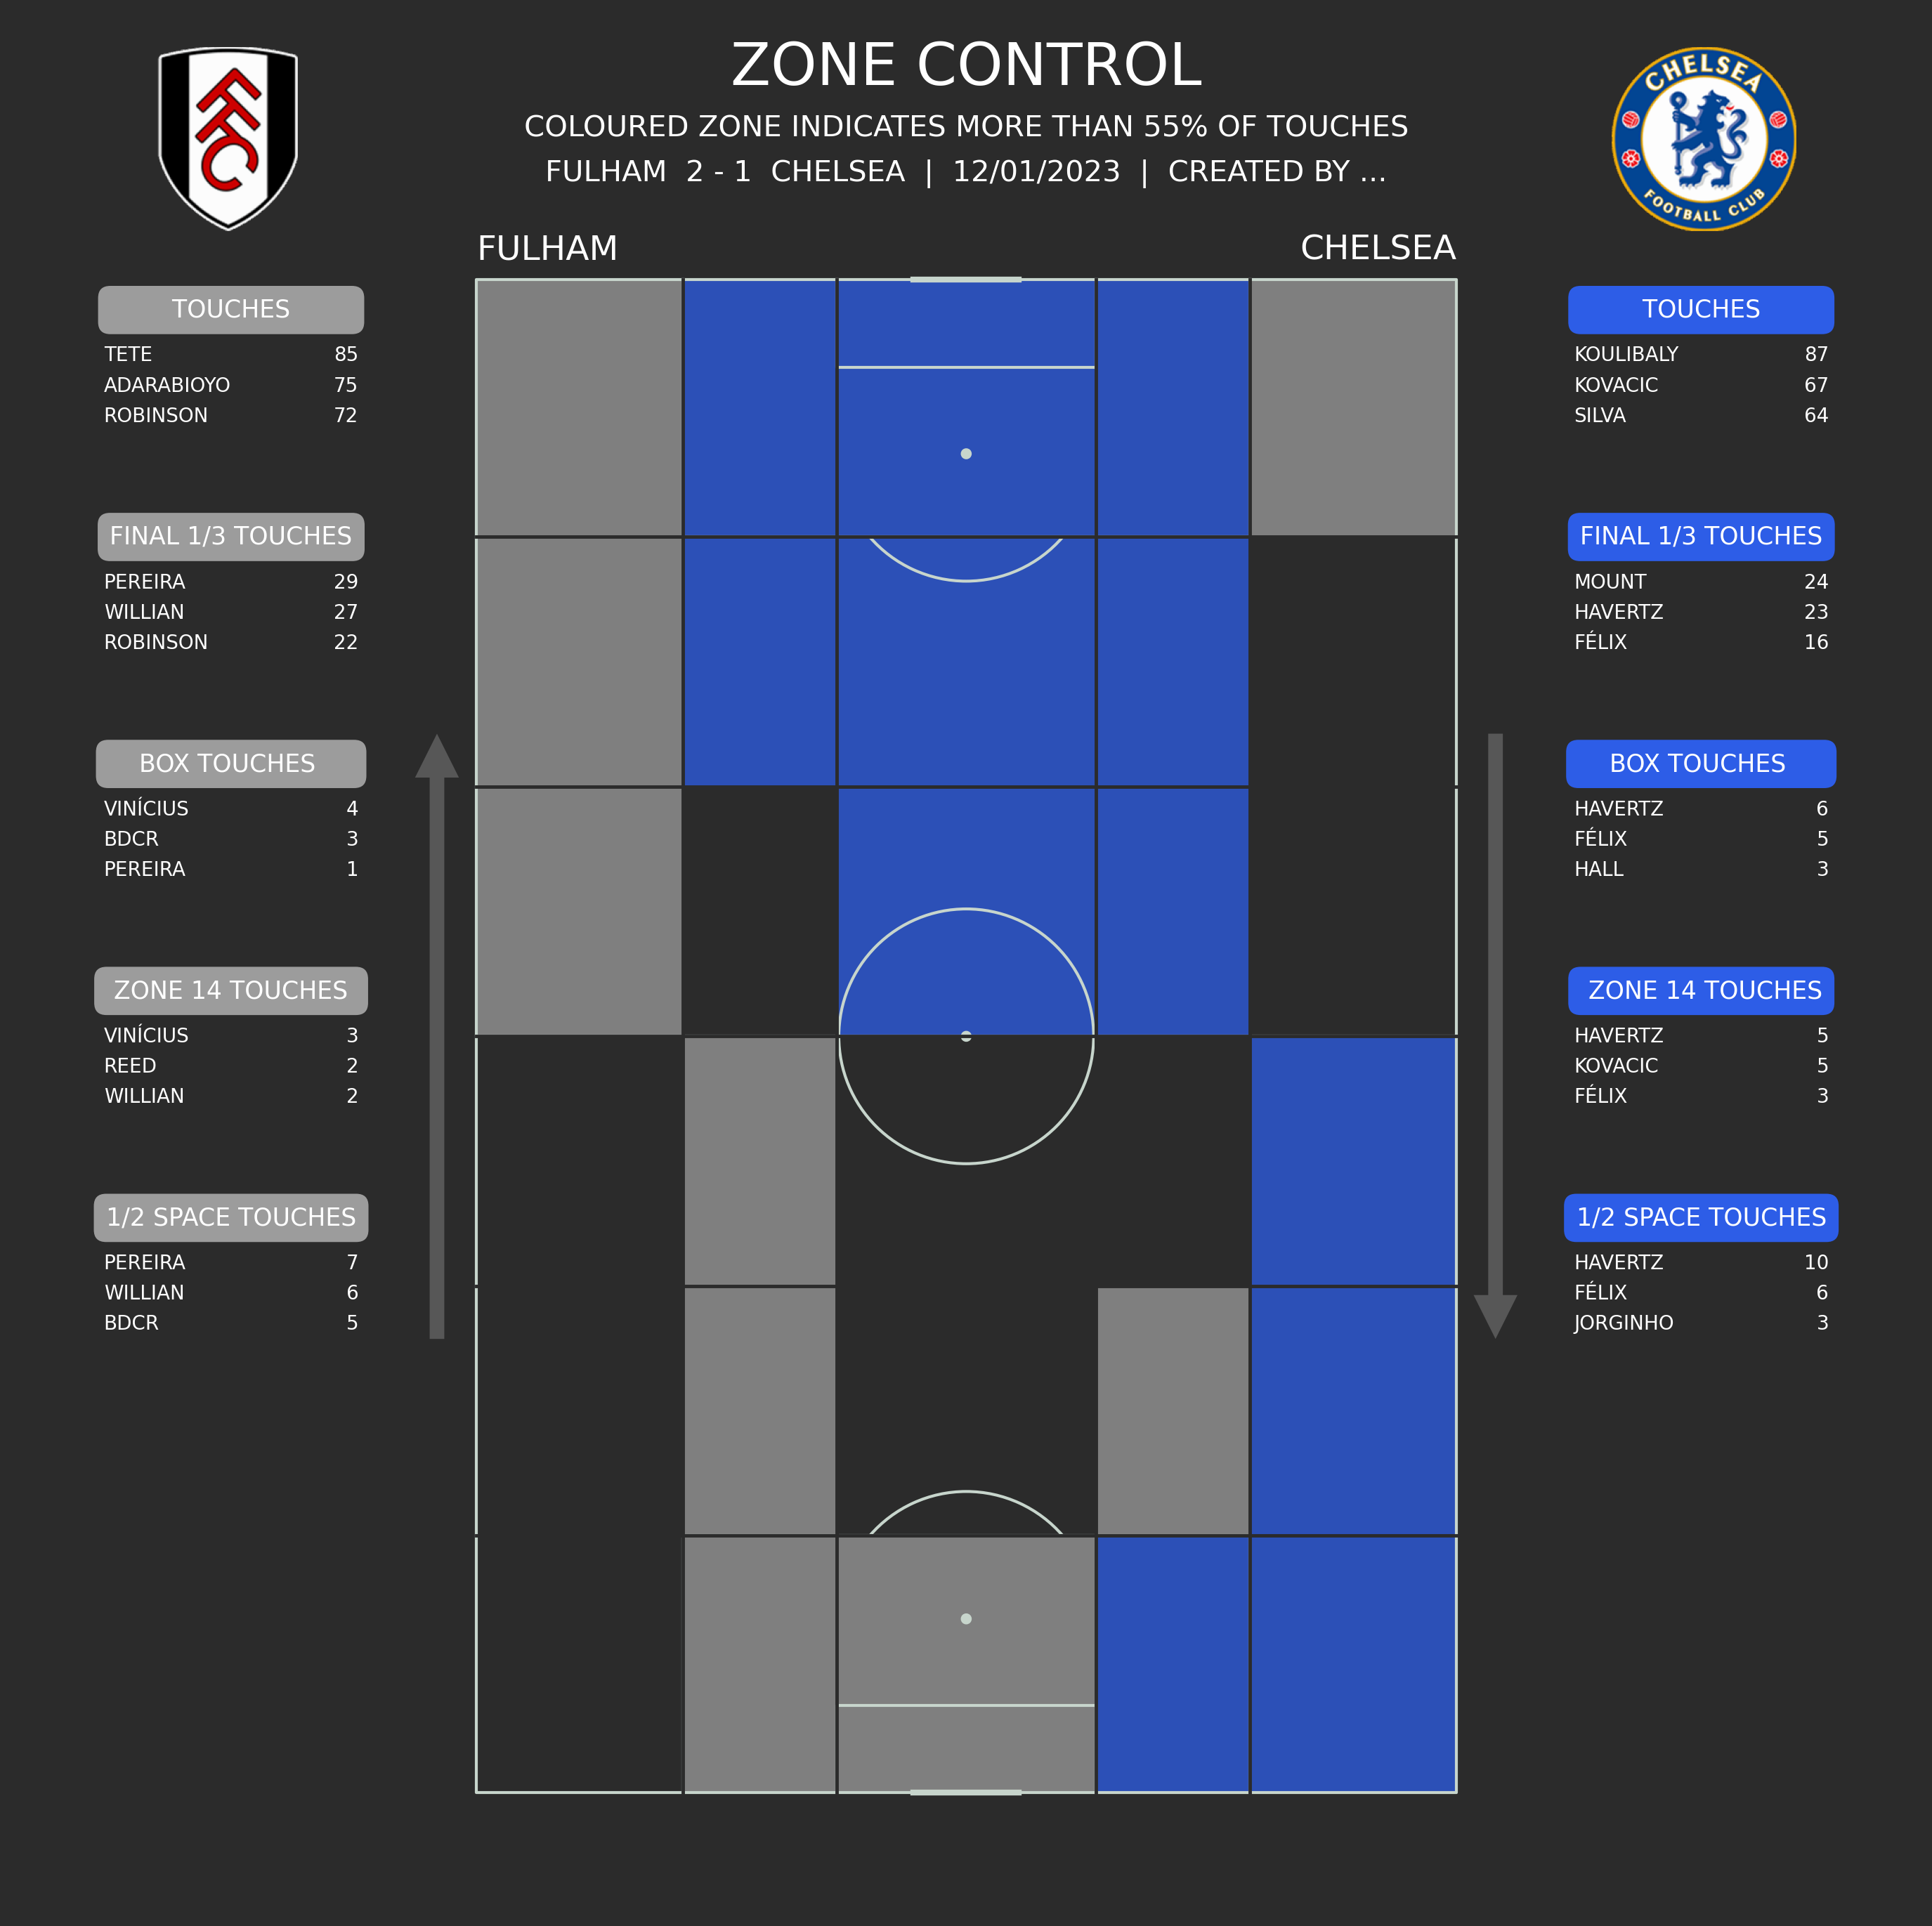

In [20]:
fig = plt.figure(figsize = (7,7), dpi = 500)
ax = plt.subplot(111)
zoneControl(ax)

In [21]:
fig.savefig('zoneControl.png', 
            bbox_inches="tight",
            edgecolor="none",
            dpi=1200)